# Configurações iniciais

#### Importanto bibliotecas

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import psycopg2
conexao = psycopg2.connect(database = "PROJETO_BI", host = "localhost", user = "postgres", password = "123456", port = "5432")
print(conexao.info)

#### Carregando tabela Vendas

In [2]:
cursor = conexao.cursor()
cursor.execute('select * from fato_vendas')
dados = cursor.fetchall()
df_vendas = pd.DataFrame(dados)

nome_colunas = ['sk_vendas','id_ordem','vl_preco','vl_frete','desc_pagamento','sk_data','sk_avaliacao','sk_cliente','sk_prazos','sk_produtos','sk_vendedor']
df_vendas.columns = nome_colunas


#### Carregando tabela Clientes

In [3]:
cursor = conexao.cursor()
cursor.execute('select * from dim_cliente')
dados = cursor.fetchall()
df_clientes = pd.DataFrame(dados)

nome_colunas = ['sk_cliente','id_cliente','nm_cidade_cliente','nm_estado_cliente']
df_clientes.columns = nome_colunas

#### Carregando tabela Tempo

In [4]:
ursor = conexao.cursor()
cursor.execute('select * from dim_tempo')
dados = cursor.fetchall()
df_tempo = pd.DataFrame(dados)

nome_colunas = ['sk_data','data_compra','nr_ano','nr_mes','nr_dia_mes', 'nr_dia_semana', 'nr_trimestre', 'desc_semana', 'desc_mes', 'desc_feriado', 'flag_feriado']
df_tempo.columns = nome_colunas

# --------------------------------------------------------------------------------------------------------------

# Vendas por localidade

In [5]:
df_merge = df_vendas.merge(df_clientes, on='sk_cliente', how= 'left')

df_merge = df_merge.merge(df_tempo, on='sk_data', how= 'left')


df_merge['vl_preco'] = pd.to_numeric(df_merge['vl_preco'])
df_merge['data_compra'] = pd.to_datetime(df_merge['data_compra'])


### Data mínima e máxima

In [6]:
df_merge['data_compra'].min()

Timestamp('2016-10-03 00:00:00-0300', tz='UTC-03:00')

In [7]:
df_merge['data_compra'].max()

Timestamp('2018-08-29 00:00:00-0300', tz='UTC-03:00')

###### O intervalo de tempo das vendas é do dia 03/10/2016 à 29/08/2018

### Vendas por estado

In [8]:
vendas_estado = df_merge[['nm_estado_cliente','vl_preco']].groupby('nm_estado_cliente').sum().sort_values(by='vl_preco', ascending=False).reset_index()
vendas_estado

,nm_estado_cliente,vl_preco
0,SP,5307710.12
1,RJ,1845341.23
2,MG,1606284.43
3,RS,766014.18
4,PR,688718.43
5,SC,523714.24
6,BA,520942.37
7,DF,306949.63
8,GO,297983.08
9,ES,277504.07


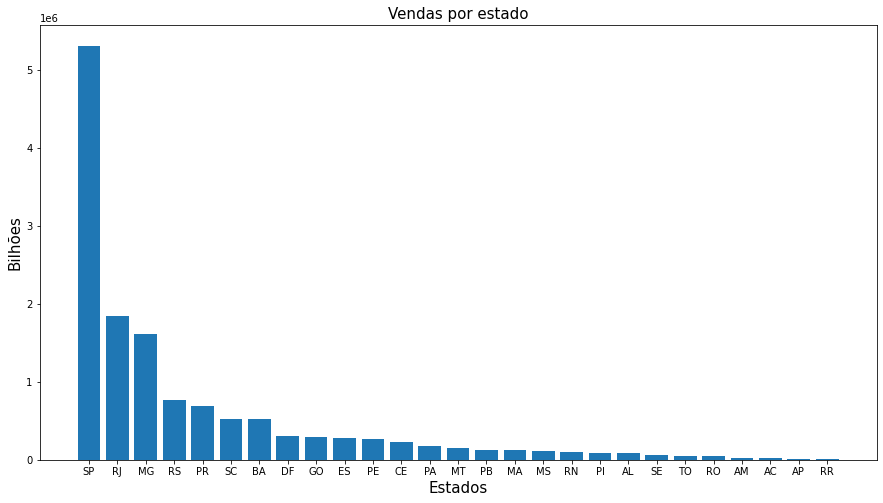

In [11]:
fig, ax = plt.subplots(figsize=(15,8))
ax.bar(vendas_estado['nm_estado_cliente'], vendas_estado['vl_preco'])
plt.title('Vendas por estado', size = 15)
plt.xlabel('Estados', size = 15)
plt.ylabel('Bilhões', size = 15)

plt.show()

#### Podemos ver que os 5 estados com mais vendas são: SP, RJ, MG, RS e PR. Com destaque para o estado de SP que mais que o dobro de vendas comparado a qualquer estado.

# --------------------------------------------------------------------------------------------------------------

# Vendas por ano

#### O intervalor de tempo dos dados não possuei 2 anos completos, portanto vamos dividir em 2 intervalos: 03/10/2016 à 03/10/2017 e 04/10/2017 à 29/08/2018.

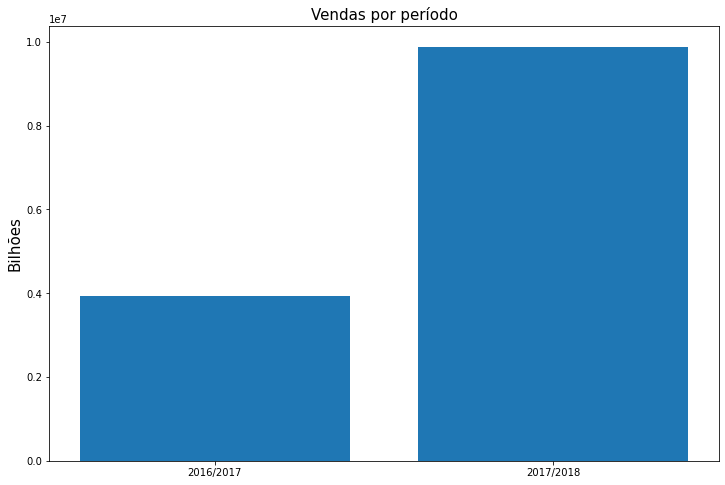

In [13]:
ano_2016_2017 = df_merge.loc[df_merge['data_compra'] <= pd.to_datetime('2017-10-03 00:00:00-03:00')]
ano_2017_2018 = df_merge.loc[df_merge['data_compra'] >= pd.to_datetime('2017-10-04 00:00:00-03:00')]
anos = ['2016/2017', '2017/2018']

vendas = [ano_2016_2017['vl_preco'].sum(), ano_2017_2018['vl_preco'].sum()]

fig, ax = plt.subplots(figsize=(12,8))
ax.bar(anos, vendas)
plt.title('Vendas por período', size = 15)
plt.rcParams['ytick.labelsize'] = 15

plt.ylabel('Bilhões', size = 15)

plt.show()

#### Podemos ver que em cerca de um ano as vendas pelo marketplace dobraram passando de 0,4 Bi para aproximadadmente 1 Bi de reais.


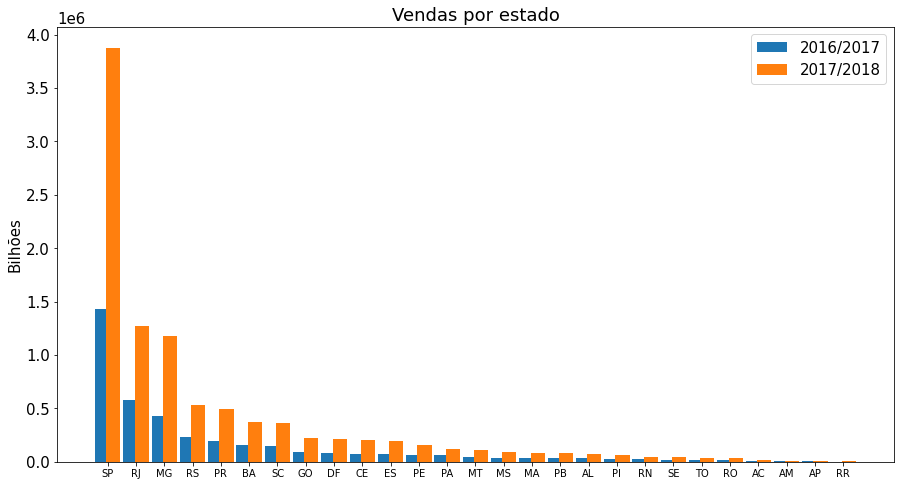

In [22]:
periodo1 = ano_2016_2017[['nm_estado_cliente','vl_preco']].groupby('nm_estado_cliente').sum().sort_values(by='vl_preco', ascending=False).reset_index()
periodo2 = ano_2017_2018[['nm_estado_cliente','vl_preco']].groupby('nm_estado_cliente').sum().sort_values(by='vl_preco', ascending=False).reset_index()

p1_estados= periodo1['nm_estado_cliente']
p2_estados= periodo2['nm_estado_cliente']
p1_vendas = periodo1['vl_preco']
p2_vendas = periodo2['vl_preco']

fig, ax = plt.subplots(figsize=(15,8))
w = 0.5
n = periodo1['nm_estado_cliente'].count()
x = np.arange(n)

bar1=plt.bar(x-0.2, p1_vendas, w,  label='2016/2017')
bar2=plt.bar(x+0.2, p2_vendas, w, label='2017/2018')
plt.xticks(x,periodo1['nm_estado_cliente'])
plt.title('Vendas por estado', size = 18)

plt.ylabel('Bilhões', size = 15)
plt.legend(fontsize=15)
plt.show()

#### Como podemos ver, as vendas mais que dobraram em todos os estados neste último período

# -------------------------------------------------------------------------------------------------------------

# Vendas por mês

#### Vamos analisar as vendas mês a mês do ultimo ano a contar pela data do ultimo registro

In [14]:
ultimo_ano = df_merge.loc[df_merge['data_compra'] >= pd.to_datetime('2017-08-30 00:00:00-03:00')]

In [15]:
mensal = ultimo_ano[['desc_mes','vl_preco']].groupby('desc_mes').sum().sort_values(by='vl_preco', ascending=False).reset_index()
mensal

,desc_mes,vl_preco
0,NOVEMBRO,1022688.86
1,MAIO,1012647.65
2,ABRIL,1006279.64
3,MARCO,994744.41
4,JANEIRO,961101.67
5,AGOSTO,918983.10
6,JUNHO,900139.68
7,JULHO,897484.91
8,FEVEREIRO,860867.82
9,DEZEMBRO,752372.57


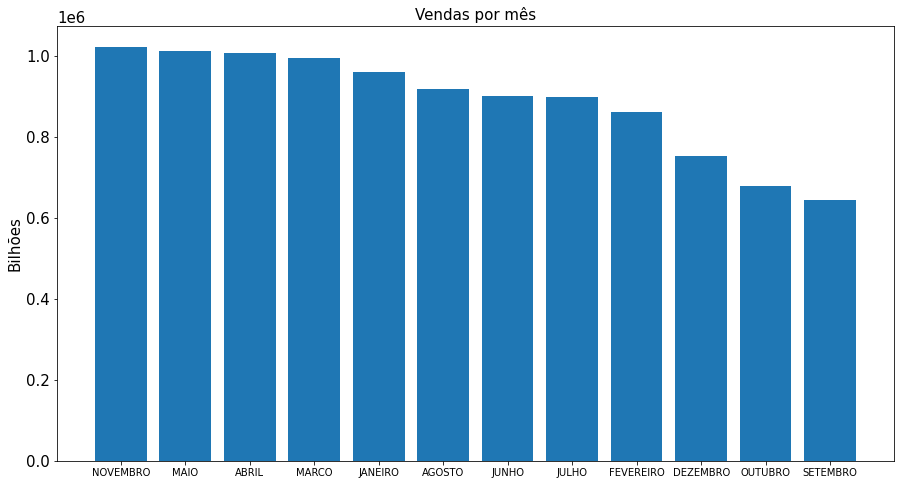

In [16]:
fig, ax = plt.subplots(figsize=(15,8))
ax.bar(mensal['desc_mes'], mensal['vl_preco'])
plt.title('Vendas por mês', size = 15)

plt.ylabel('Bilhões', size = 15)
plt.xticks(fontsize=10)
plt.show()

#### Temos Novembro como o mês de maior faturamento no ultimo ano, provavelmente por ser o mês que acontece a Blackfriday.

# --------------------------------------------------------------------------------------------------------------

# Ticket médio por estado

In [17]:
media_estado = df_merge[['nm_estado_cliente','vl_preco']].groupby('nm_estado_cliente').mean().sort_values(by='vl_preco', ascending=False).reset_index()
media_estado

,nm_estado_cliente,vl_preco
0,PB,194.293868
1,AL,185.150272
2,AC,180.930426
3,RN,166.889893
4,RO,165.502313
5,PA,165.074000
6,TO,164.768503
7,AP,163.310964
8,PI,162.549060
9,CE,154.717085


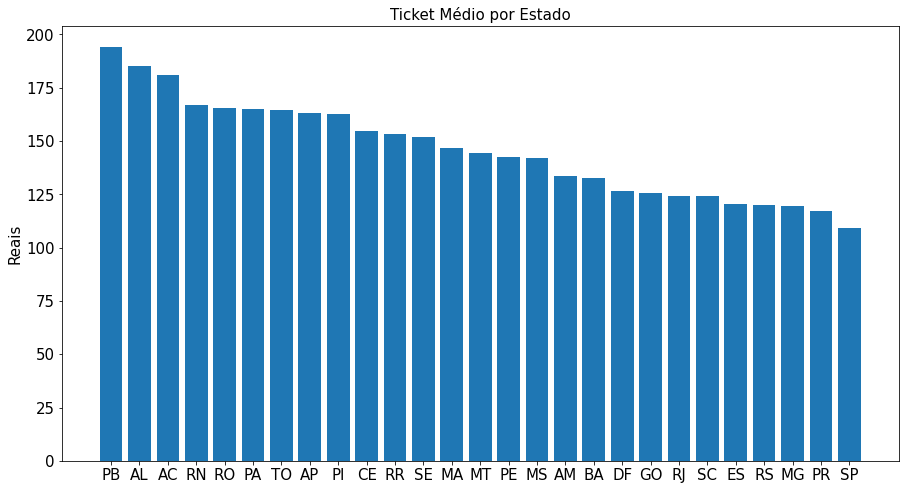

In [18]:
fig, ax = plt.subplots(figsize=(15,8))
ax.bar(media_estado['nm_estado_cliente'], media_estado['vl_preco'])
plt.title('Ticket Médio por Estado', size = 15)

plt.ylabel('Reais', size = 15)
plt.xticks(fontsize=15)
plt.show()

#### A Paraiba é o estado com o maior ticket médio, e um fato curioso é que São Paulo é o estado de maior faturamento e o de menor ticket médio.

# Forma de pagamento 

In [20]:
pagamento= df_merge['desc_pagamento'].value_counts().reset_index()


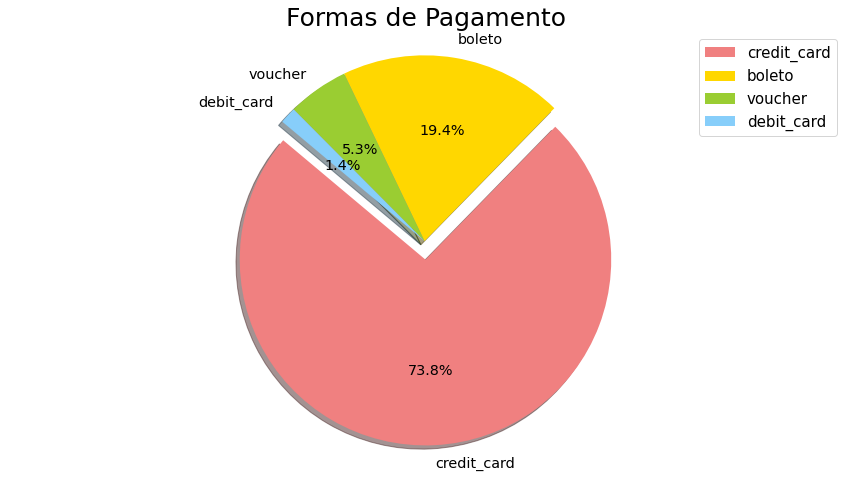

In [21]:
# Dados para plotar
labels = pagamento['desc_pagamento']
tamanhos = pagamento['count']
plt.figure(figsize=(15, 8))
# definições
colors = ['lightcoral','gold', 'yellowgreen',  'lightskyblue']

# explodir 1ª fatia
explode = (0.1, 0, 0, 0)  

# Plot
plt.pie(tamanhos, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140, textprops={'size': 'x-large'})


plt.legend(labels, loc="upper right", fontsize = 15)
plt.title('Formas de Pagamento', size = 25)
plt.axis('equal')
plt.show()